# Spatial Correlations of bacterial suspensions

Here we use spatial correlaitons (orientation, velocity and pixel intensity) to identify the transition from disordered phase to ordered phase. 

We also compare the concentration dependence of correlation length with that of GNF scaling exponent $\alpha$.

## Table of contents

1. Intensity spatial correlation function
    - Summarize the data
    - Intensity correlation at different concentrations
        - Generate data
        - Plot data
    - Calculate correlation length
        - Generate data
        - Plot data 
2. Velocity spatial correlation function
    - Summarize the data
    - Velocity correlation at different concentrations
        - Generate data
        - Plot data
    - Calculate correlation length
        - Generate data
        - Plot data 

## 0 Packages and presets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from myImageLib import dirrec, bestcolor, bpass, wowcolor
from skimage import io, measure, util
import pandas as pd
from scipy.signal import savgol_filter, medfilt
import os
from corrLib import *
from scipy.signal import savgol_filter
import matplotlib as mpl
from scipy.optimize import curve_fit
from miscLib import label_slope
from corrLib import density_fluctuation
from scipy import signal
from scipy.interpolate import griddata
import matplotlib
import pandas as pd
import time
from corr_utils import *
from pivLib import PIV1
import typesetting.main as tm

In [2]:
color_dict, marker_list = unified_symbols() # keep color and symbol consistent across different plot, for same concentrations
data_master_dir = r'E:\Google Drive' # data folder: Google drive for now, but may change in the future
tm.prl('1-column-2-panel') # control the default plotting configurations, now I realize the parameters should vary from plot to plot
dirs = data_log_mapping(kw='aug') # video info for GNF raw data, obtained from Aug 3rd to Aug 6th

## 1 Intensity spatial correlation function

### 1.1 Summarize the data

The raw data is already a DF of (C, R). Here, I will bin the data and move data of each day to summary.csv file. Since I know that the maximum correlation length is 5 $l_b$, the range I plan to plot the correlation functions is 5 times of it, i.e. 400 pixels.

Average should be taken for long time data. Here, we choose 0.8 percentile. 

In [9]:
conc, folders, sample_num = tentative_log()
upper_length = 400 # px
master_folder = r'E:\moreData\{}\corr_imseq' # corr_imseq folder, containing subfolders for different samples
for folder in folders:
    f = master_folder.format(folder)
    sfL = next(os.walk(f))[1]
    for count, sf in enumerate(sfL):
        data_folder = os.path.join(f, sf)
        l = readdata(data_folder, 'csv')
        l_crop = l[int(len(l)*0.9):] # only take long time data
        y_list = [] # empty list for storing CF
        for num, i in l_crop.reset_index().iterrows():
            ci = pd.read_csv(i.Dir).set_index('R')[:upper_length]
            bins = np.linspace(0, upper_length, 100)
            x, y = xy_bin(ci.index, ci.C, bins=bins)
            y_list.append(y)
        y_mean = np.stack(y_list, axis=0).mean(axis=0)
        temp = pd.DataFrame({'R': x, sf: y_mean}).set_index('R')
        if count == 0:
            ci_DF = temp
        else:
            ci_DF = pd.concat((ci_DF, temp), axis=1)
    ci_DF.to_csv(os.path.join(f, 'summary.csv'))            

E:\Github\Python\Correlation\src\corr_utils.py:1301: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])


Text(0, 0.5, '$C_{n}$')

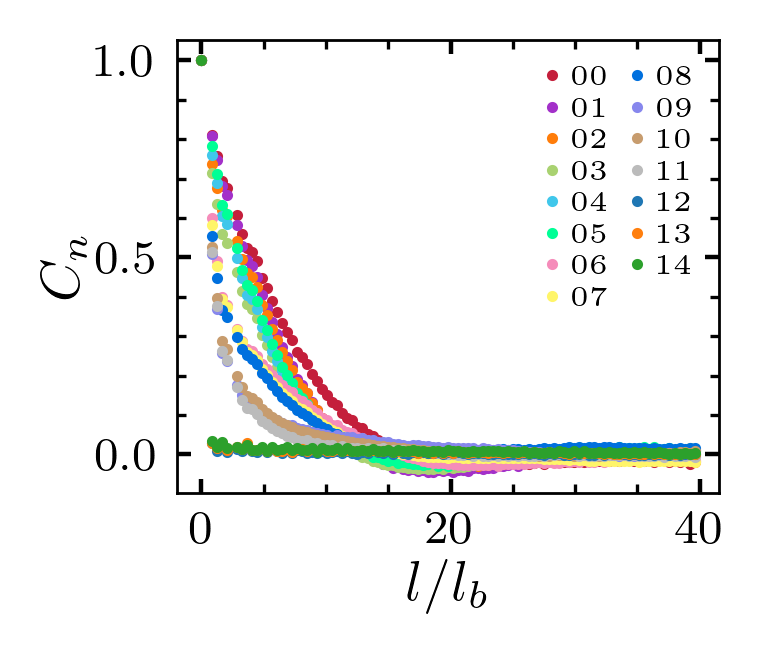

In [7]:
fig, ax = plt.subplots()
lb = 10 # px
for num, kw in enumerate(ci_DF):
    ax.plot(ci_DF.index/lb, ci_DF[kw], 
            ls='', marker='o', markersize=1, label=kw,
            color=wowcolor(num))
ax.legend(fontsize=5, ncol=2)
ax.set_xlabel('$l/l_b$')
ax.set_ylabel('$C_{n}$')

### 1.2 Intensity correlation at different concentrations

#### 1.2.1 Generate data

In [27]:
conc, folders, sample_num = tentative_log()
master_file = os.path.join(data_master_dir, r'Research projects\DF\data\level-2-data\{0}\corr_imseq\summary.csv')
data = pd.DataFrame() # empty DF to store data from different concentrations
for c, f, sn in zip(conc, folders, sample_num):
    summary = pd.read_csv(master_file.format(f)).set_index('R')
    keys = []
    for n in sn:
        keys.append('{:02d}'.format(n))
    temp_data = summary[keys].mean(axis=1).to_frame(str(c))
    data = pd.concat((data, temp_data), axis=1)
data.to_csv(os.path.join(data_master_dir, r'Research projects\DF\data\spatial-correlation\intensity-correlation.csv'))

#### 1.2.2 Plot data

Text(0, 0.5, '$C_{n}$')

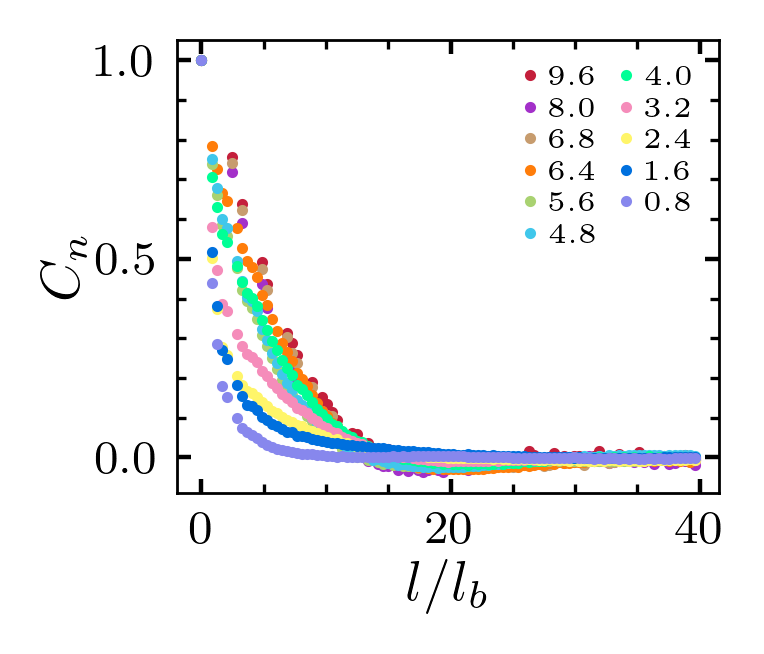

In [37]:
data = pd.read_csv(os.path.join(data_master_dir, 
                                r'Research projects\DF\data\spatial-correlation\intensity-correlation.csv')).set_index('R')
fig, ax = plt.subplots()
lb = 10 # px
for kw in data:
    ax.plot(data.index/lb, data[kw],
            ls='', marker='o', markersize=1, label='{:.1f}'.format(int(kw)*0.08),
            color=wowcolor(color_dict[kw]))
ax.legend(fontsize=5, ncol=2)
ax.set_xlabel('$l/l_b$')
ax.set_ylabel('$C_{n}$')

### 1.3 Calculate correlation length

Use the function `corr_length()`

#### 1.3.1 Generate data

In order to have error bars, use level-2-data instead of the averaged intensity-correlation.csv.

In [80]:
conc, folders, sample_num = tentative_log()
master_file = os.path.join(data_master_dir, r'Research projects\DF\data\level-2-data\{0}\corr_imseq\summary.csv')
data = pd.DataFrame() # empty DF to store data from different concentrations
for c, f, sn in zip(conc, folders, sample_num):
    summary = pd.read_csv(master_file.format(f)).set_index('R')
    temp_cl_list = [] # store the 3 correlation lengths for each concentrations
    for n in sn:
        temp_data = summary['{:02d}'.format(n)].to_frame('C').dropna().reset_index()
        cl, fit = corr_length(temp_data)
        temp_cl_list.append(cl)
    temp_cl_DF = pd.DataFrame({str(c): temp_cl_list})
    data = pd.concat([data, temp_cl_DF], axis=1)
data = data.transpose()
data = data.set_index(data.index.astype('int')).sort_index()
data = data.assign(avg=data.mean(axis=1), err=data.std(axis=1))
data.index.rename('conc', inplace=True)
data.to_csv(os.path.join(data_master_dir, r'Research projects\DF\data\spatial-correlation\intensity-correlation-length.csv'))

In [81]:
data

,0,1,2,avg,err
conc,,,,,
10,9.885995,10.632332,10.506247,10.341525,0.399506
20,15.079764,16.589002,14.507427,15.392065,1.075354
30,11.527292,22.205106,19.148741,17.627046,5.499145
40,28.909372,27.128720,25.228572,27.088888,1.840723
50,43.716428,40.989751,39.862917,41.523032,1.981333
60,36.018274,39.437278,40.783084,38.746212,2.456427
70,34.604914,39.212647,37.407328,37.074963,2.321778
80,53.314318,45.257558,43.316688,47.296188,5.301430
85,51.832762,52.795273,47.245445,50.624493,2.965650


#### 1.3.2 Plot data

(0.0, 10.0)

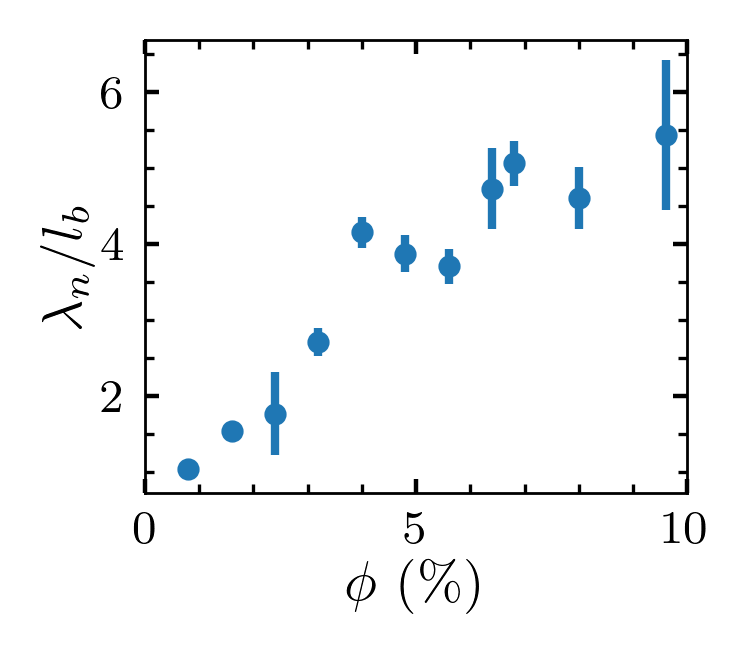

In [82]:
cl_data = pd.read_csv(os.path.join(data_master_dir, 
                                   r'Research projects\DF\data\spatial-correlation\intensity-correlation-length.csv'))
fig, ax = plt.subplots()
ax.errorbar(cl_data['conc']*0.08, cl_data['avg']/lb, yerr=cl_data['err']/lb, 
        ls='', marker='o', markersize=3, label='{:.1f}'.format(int(kw)*0.08))
ax.set_xlabel('$\phi$ (\%)')
ax.set_ylabel('$\lambda_n/l_b$')
ax.set_xlim([0, 10])

## 2 Velocity spatial correlation function

### 2.1 Summarize the data

The raw data is a DF of (X, Y, CA, CV). Here, I will first convert it to (R, CA, CV) and then bin the data and move data of each day to summary.csv file. Since I know that the maximum correlation length is 15 $l_b$, the range I plan to plot the correlation functions is 5 times of it, i.e. 800 pixels.

Average should be taken for long time data. Here, we choose 0.8 percentile. 

In [108]:
conc, folders, sample_num = tentative_log()
upper_length = 800 # px
master_folder = r'E:\moreData\{}\cav_imseq' # corr_imseq folder, containing subfolders for different samples
for folder in folders:
    f = master_folder.format(folder)
    sfL = next(os.walk(f))[1]
    for count, sf in enumerate(sfL):
        data_folder = os.path.join(f, sf)
        l = readdata(data_folder, 'csv')
        l_crop = l[int(len(l)*0.9):] # only take long time data
        ca_list = [] # empty list for storing CF
        cv_list = [] # empty list for storing CF
        for num, i in l_crop.reset_index().iterrows():
            c = pd.read_csv(i.Dir)
            c = c.assign(R=(c.X**2+c.Y**2)**0.5)
            c.R = c.R - c.R.min()
            c = c.set_index('R')
            c = c[c.index < upper_length]
            bins = np.linspace(0, upper_length, 100)
            x, y = xy_bin(c.index, c.CA, bins=bins)
            ca_list.append(y)
            x, y = xy_bin(c.index, c.CV, bins=bins)
            cv_list.append(y)
        ca_mean = np.stack(ca_list, axis=0).mean(axis=0)
        cv_mean = np.stack(cv_list, axis=0).mean(axis=0)
        ca_temp = pd.DataFrame({'R': x, sf: ca_mean}).set_index('R')
        cv_temp = pd.DataFrame({'R': x, sf: cv_mean}).set_index('R')
        if count == 0:
            ca_DF = ca_temp
            cv_DF = cv_temp
        else:
            ca_DF = pd.concat((ca_DF, ca_temp), axis=1)
            cv_DF = pd.concat((cv_DF, cv_temp), axis=1)
    ca_DF.to_csv(os.path.join(f, 'ca-summary.csv'))  
    cv_DF.to_csv(os.path.join(f, 'cv-summary.csv')) 

E:\Github\Python\Correlation\src\corr_utils.py:1301: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])


Text(0, 0.5, '$C_{v}$')

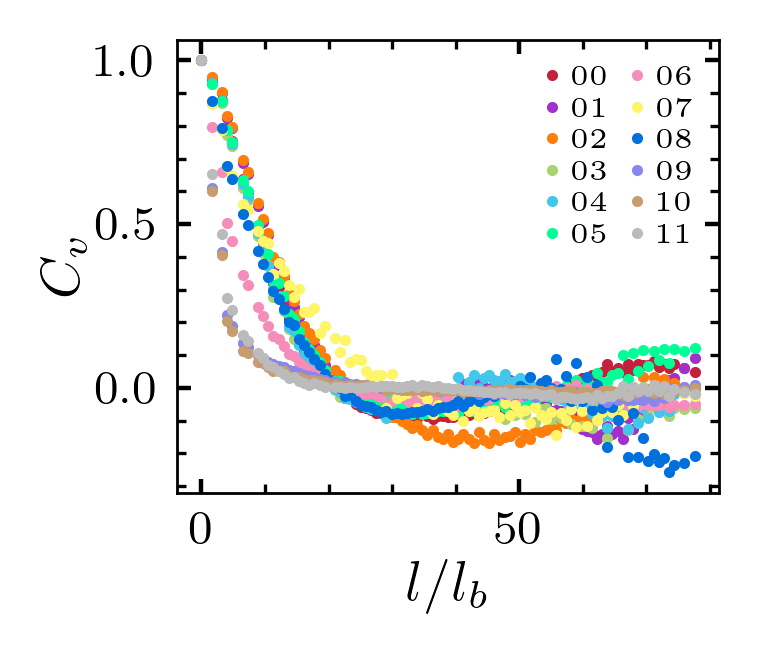

In [109]:
fig, ax = plt.subplots()
lb = 10 # px
for num, kw in enumerate(ci_DF):
    ax.plot(cv_DF.index/lb, cv_DF[kw], 
            ls='', marker='o', markersize=1, label=kw,
            color=wowcolor(num))
ax.legend(fontsize=5, ncol=2)
ax.set_xlabel('$l/l_b$')
ax.set_ylabel('$C_{v}$')

### 1.2 Velocity correlation at different concentrations

#### 1.2.1 Generate data

In [114]:
conc, folders, sample_num = tentative_log()
master_file = os.path.join(data_master_dir, r'Research projects\DF\data\level-2-data\{0}\cav_imseq\cv-summary.csv')
data = pd.DataFrame() # empty DF to store data from different concentrations
for c, f, sn in zip(conc, folders, sample_num):
    summary = pd.read_csv(master_file.format(f)).set_index('R')
    keys = []
    for n in sn:
        keys.append('{:02d}'.format(n))
    temp_data = summary[keys].mean(axis=1).to_frame(str(c))
    data = pd.concat((data, temp_data), axis=1)
data.dropna(inplace=True)
data.to_csv(os.path.join(data_master_dir, r'Research projects\DF\data\spatial-correlation\velocity-correlation.csv'))

#### 1.2.2 Plot data

Text(0, 0.5, '$C_{v}$')

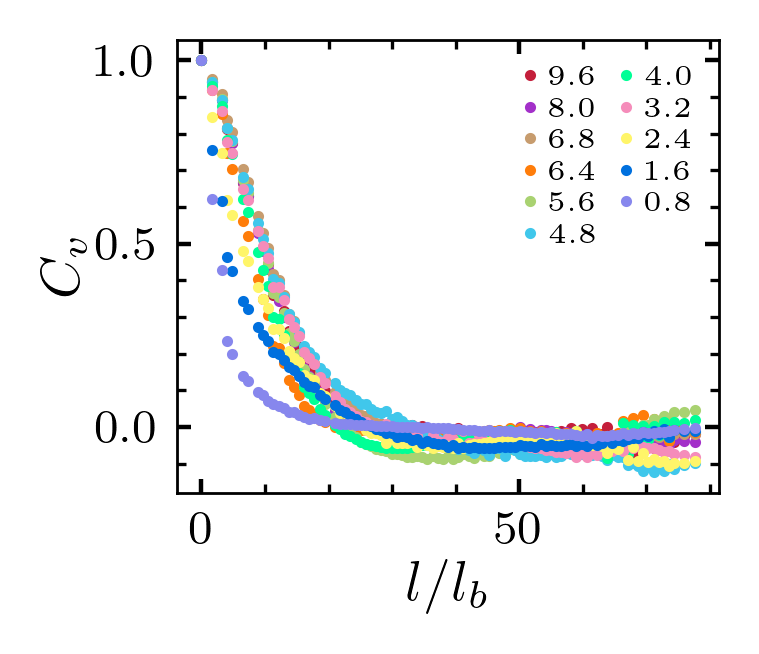

In [116]:
data = pd.read_csv(os.path.join(data_master_dir, 
                                r'Research projects\DF\data\spatial-correlation\velocity-correlation.csv')).set_index('R')
fig, ax = plt.subplots()
lb = 10 # px
for kw in data:
    ax.plot(data.index/lb, data[kw],
            ls='', marker='o', markersize=1, label='{:.1f}'.format(int(kw)*0.08),
            color=wowcolor(color_dict[kw]))
ax.legend(fontsize=5, ncol=2)
ax.set_xlabel('$l/l_b$')
ax.set_ylabel('$C_{v}$')

### 1.3 Calculate correlation length

Use the function `corr_length()`

#### 1.3.1 Generate data

In order to have error bars, use level-2-data instead of the averaged intensity-correlation.csv.

In [119]:
conc, folders, sample_num = tentative_log()
master_file = os.path.join(data_master_dir, r'Research projects\DF\data\level-2-data\{0}\cav_imseq\cv-summary.csv')
data = pd.DataFrame() # empty DF to store data from different concentrations
for c, f, sn in zip(conc, folders, sample_num):
    summary = pd.read_csv(master_file.format(f)).set_index('R')
    temp_cl_list = [] # store the 3 correlation lengths for each concentrations
    for n in sn:
        temp_data = summary['{:02d}'.format(n)].to_frame('C').dropna().reset_index()
        cl, fit = corr_length(temp_data)
        temp_cl_list.append(cl)
    temp_cl_DF = pd.DataFrame({str(c): temp_cl_list})
    data = pd.concat([data, temp_cl_DF], axis=1)
data = data.transpose()
data = data.set_index(data.index.astype('int')).sort_index()
data = data.assign(avg=data.mean(axis=1), err=data.std(axis=1))
data.index.rename('conc', inplace=True)
data.to_csv(os.path.join(data_master_dir, r'Research projects\DF\data\spatial-correlation\velocity-correlation-length.csv'))

#### 1.3.2 Plot data

(0.0, 10.0)

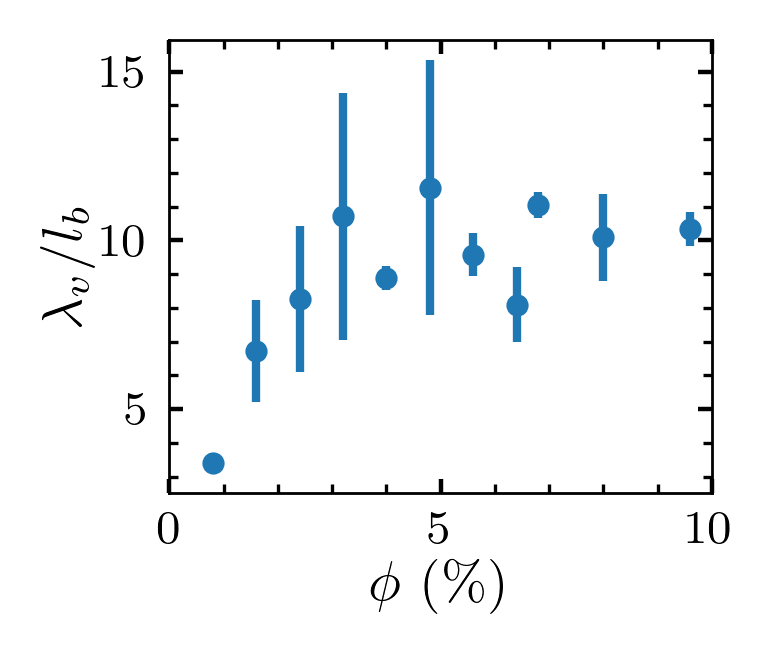

In [120]:
cl_data = pd.read_csv(os.path.join(data_master_dir, 
                                   r'Research projects\DF\data\spatial-correlation\velocity-correlation-length.csv'))
fig, ax = plt.subplots()
ax.errorbar(cl_data['conc']*0.08, cl_data['avg']/lb, yerr=cl_data['err']/lb, 
        ls='', marker='o', markersize=3, label='{:.1f}'.format(int(kw)*0.08))
ax.set_xlabel('$\phi$ (\%)')
ax.set_ylabel('$\lambda_v/l_b$')
ax.set_xlim([0, 10])